# Khan 2018 Mouse Lens Re-analysis

## Lens changes with age notebook

### Prepared by Phil Wilmarth, PSR Core, OHSU

### August 29, 2023

---

- [Overview](#overview) 
- [Data loading](#load_data)
- [Age comparison using all samples](#Age)
- [Summary](#summary)

---

## <a name="overview"></a>Overview

This is a three plex experiment using 10-plex TMT with no reference channels per plex. Each plex is a set of biological replicates of developing mouse lens: E15, E18, P0, P3, P6, P9 (six ages, 3 day intervals). Data were downloaded from PRIDE (PXD006381) and processed with the [PAW Pipeline](https://github.com/pwilmart/PAW_pipeline) (*Wilmarth 2009*) and IRS normalized using the average of each plex as a mock reference channel (*Plubell 2017*). This is the publication:

> Khan, S.Y., Ali, M., Kabir, F., Renuse, S., Na, C.H., Talbot, C.C., Hackett, S.F. and Riazuddin, S.A., 2018. Proteome profiling of developing murine lens through mass spectrometry. Investigative Ophthalmology & Visual Science, 59(1), pp.100-107.

#### Experimental Groups:

Age|Description|Biological Replicates|Pooled Mice Lenses
---|---|---|---
E15|Embryonic day 15|3|23 embryos
E18|Embryonic day 18|3|10 embryos
P0|Newborn|3|8 pups
P3|3-day old|3|8 pups
P6|6-day old|3|8 pups
P9|9-day old|3|8 pups

#### Sample Key:

Channel|Plex 1|Plex 2|Plex 3
---|---|---|---
126C|E15|E15|E15
127N|E18|E18|E18
127C|P0|P0|P0
128N|P3|P3|P3
128C|P6|P6|P6
129N|P9|P9|P9
129C|Mix?|Mix?|Mix?
130N|unused|unused|unused
130C|unused|unused|unused
131N|unused|unused|unused

### This notebook will compare lenses of different ages

There were three plexes with biological replicates of the 6 ages. There was no pooled internal reference standard. The plex average intensity for each protein was used as a mock reference intensity vector. IRS was used to put all three plexes (18 samples) on a common intensity scale. Statistical analysis was done with edgeR (*Robinson 2010A*) using the linear modeling functions (*McCarthy 2012*) after TMM normalization (*Robinson 2010B*)

### References

> Wilmarth, P.A., Riviere, M.A. and David, L.L., 2009. Techniques for accurate protein identification in shotgun proteomic studies of human, mouse, bovine, and chicken lenses. Journal of ocular biology, diseases, and informatics, 2(4), pp.223-234.

> Plubell, D.L., Wilmarth, P.A., Zhao, Y., Fenton, A.M., Minnier, J., Reddy, A.P., Klimek, J., Yang, X., David, L.L. and Pamir, N., 2017. Extended multiplexing of tandem mass tags (TMT) labeling reveals age and high fat diet specific proteome changes in mouse epididymal adipose tissue. Molecular & Cellular Proteomics, 16(5), pp.873-890.

> Robinson, M.D., McCarthy, D.J. and Smyth, G.K., 2010. edgeR: a Bioconductor package for differential expression analysis of digital gene expression data. bioinformatics, 26(1), pp.139-140.

> McCarthy, DJ, Chen, Y, Smyth, GK (2012). Differential expression analysis of multifactor RNA-Seq experiments with respect to biological variation. Nucleic Acids Research 40, 4288- 4297.

> Robinson, M.D. and Oshlack, A., 2010. A scaling normalization method for differential expression analysis of RNA-seq data. Genome biology, 11(3), pp.1-9.

---

## Load the necessary R libraries

In [1]:
# library imports
library(tidyverse)
library(scales)
library(limma)
library(edgeR)
library(psych)

Warning message:
“replacing previous import ‘lifecycle::last_warnings’ by ‘rlang::last_warnings’ when loading ‘tibble’”
── Attaching packages ─────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.1     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

── Conflicts ────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘scales’


The following object is masked from ‘package:purrr’:

    discard


The following object is masked from ‘package:readr’:

    col_factor



Attaching package: ‘psych’


The following objects are masked from ‘package:scales’:

    alpha, rescale


The following objects are masked from ‘package:ggplot2’:

    %+%, alpha




## Define functions for notebook use

In [2]:
# ================== TMM normalization from DGEList object =====================
apply_tmm_factors <- function(y, color = NULL, plot = TRUE, table = TRUE, title = "TMM Normalized data") {
    # computes the tmm normalized data from the DGEList object
        # y - DGEList object
        # color - color vecotr for boxplots
        # plot - flag to make boxplots or not
        # table - flag to print normalization factor tables or not
        # title - main title for boxplot plot
        # returns a dataframe with normalized intensities
    
    # compute and print "Sample loading" normalization factors
    lib_facs <- mean(y$samples$lib.size) / y$samples$lib.size
    if(table == TRUE) {
        cat("\nLibrary size factors:\n", 
            sprintf("%-5s -> %f\n", colnames(y$counts), lib_facs))
    }
    
    # compute and print TMM normalization factors
    tmm_facs <- 1/y$samples$norm.factors
    if(table == TRUE) {
        cat("\nTrimmed mean of M-values (TMM) factors:\n", 
            sprintf("%-5s -> %f\n", colnames(y$counts), tmm_facs))
    }
    
    # compute and print the final correction factors
    norm_facs <- lib_facs * tmm_facs
    if(table == TRUE) {
        cat("\nCombined (lib size and TMM) normalization factors:\n", 
            sprintf("%-5s -> %f\n", colnames(y$counts), norm_facs))
    }

    # compute the normalized data as a new data frame
    tmt_tmm <- as.data.frame(sweep(y$counts, 2, norm_facs, FUN = "*"))
    colnames(tmt_tmm) <- str_c(colnames(y$counts), "_tmm")
    
    # visualize results and return data frame
    if(plot == TRUE) {
        boxplot(log10(tmt_tmm), col = color, notch = TRUE, main = title)
    }
    tmt_tmm
}

set_plot_dimensions <- function(width_choice, height_choice) {
    options(repr.plot.width=width_choice, repr.plot.height=height_choice)
}

# set some larger plot dimensions
set_plot_dimensions(9, 9)

## <a name="load_data"></a>Load the TMT intensity data

In [3]:
# load the IRS-normalized data and check the table
data_import <- read_tsv("labeled_grouped_protein_summary_TMT_9_IRS_normalized.txt", 
                        guess_max = 5854)

# "Filter" column flags contams and decoys
# "Missing" column flags proteins without reporter ion intensities (full sets missing)
# the table from pandas is sorted so the rows we want come first
data_all <- filter(data_import, is.na(Filter), is.na(Missing))
data_sl <- select(data_all, contains("SLNorm_"))
data_irs <- select(data_all, contains("IRSNorm_"))

# save gene names for edgeR so we can double check that results line up
accessions <- data_all$Accession

# see how many rows of data we have
length(accessions)

Parsed with column specification:
cols(
  .default = col_double(),
  Accession = col_character(),
  Identical = col_character(),
  Similar = col_character(),
  OtherLoci = col_character(),
  Filter = col_character(),
  Missing = col_character(),
  Description = col_character()
)

See spec(...) for full column specifications.



[1] 4249

### Collect the data by age 

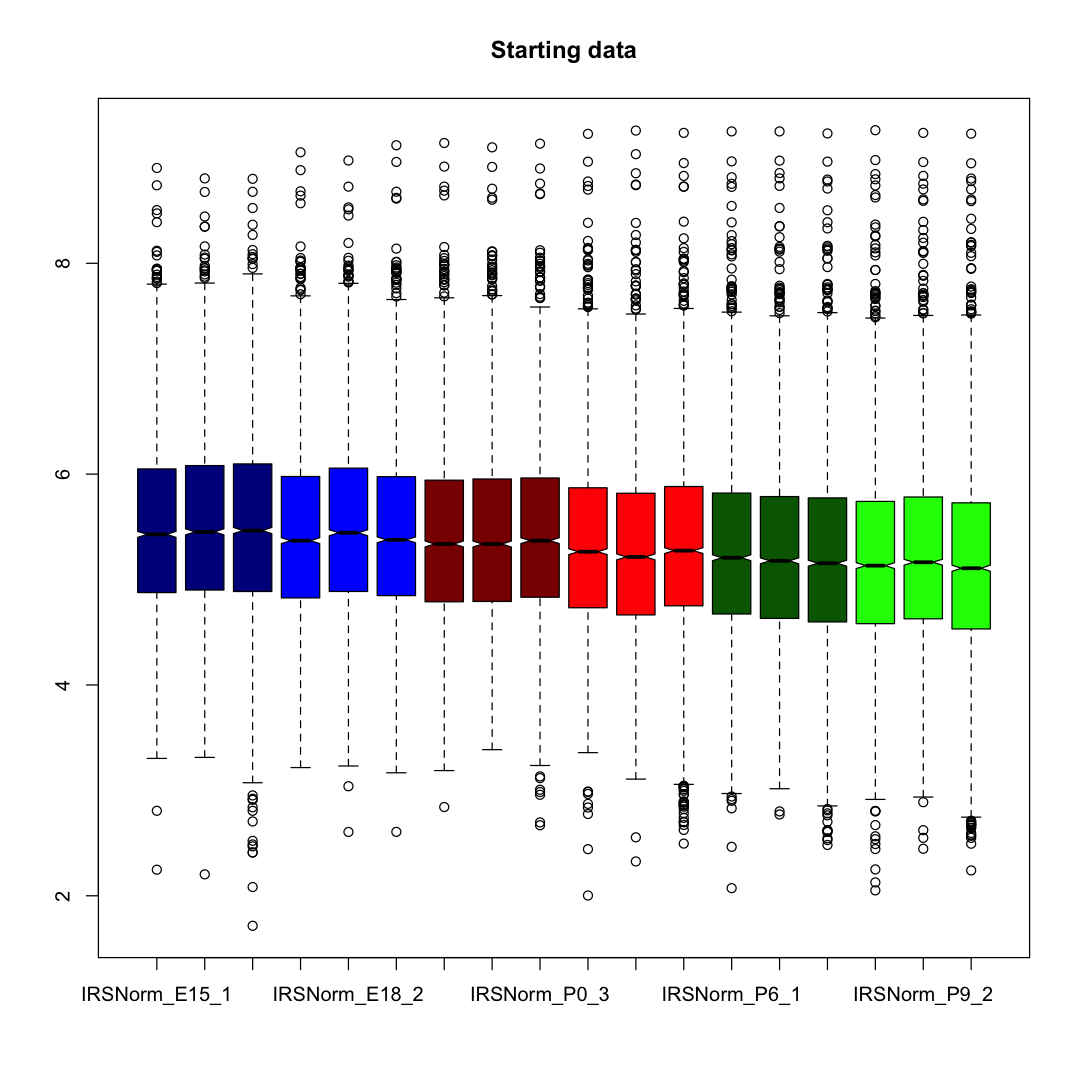

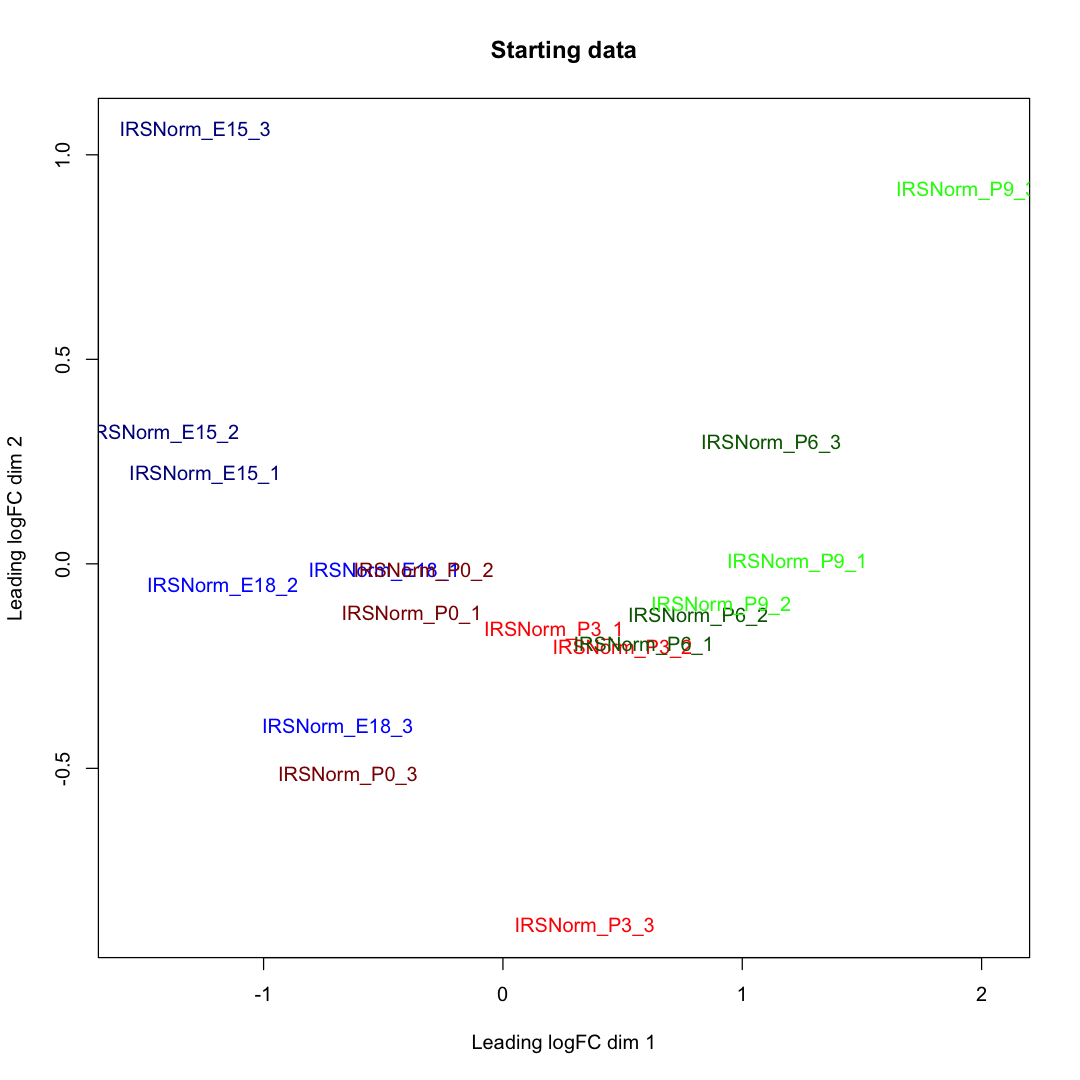

In [4]:
# define the groups (after IRS)
E15_irs <- select(data_irs, contains("_E15_"))
E18_irs <- select(data_irs, contains("_E18_"))
P0_irs <- select(data_irs, contains("_P0_"))
P3_irs <- select(data_irs, contains("_P3_"))
P6_irs <- select(data_irs, contains("_P6_"))
P9_irs <- select(data_irs, contains("_P9_"))
tmt_data <- bind_cols(E15_irs, E18_irs, P0_irs, P3_irs, P6_irs, P9_irs)

# Set color vector:
#   dark blue - E15
#   blue - E18
#   dark red - P0
#   red - P3
#   dark green - P6
#   green - P9
colors_all <- c(rep("dark blue", 3), rep("blue", 3), rep("dark red", 3), 
                rep("red", 3), rep("dark green", 3), rep("green", 3))

# set some index ranges for age groups
E15 <- 1:3
E18 <- 4:6
P0 <- 7:9
P3 <- 10:12
P6 <- 13:15
P9 <- 16:18

# plot the starting data
boxplot(log10(tmt_data), col = colors_all, notch = TRUE, main = "Starting data")

# check the clustering
plotMDS(log2(tmt_data), col = colors_all, main = "Starting data")

## <a name="Age"></a>Compare ages using all samples

Load edgeR data objects and run TMM. We will use the glm modeling in edgeR with the quasi-likelihood functions. We will load a DGEList data object, **not** run TMM normalization, and check the results.


Library size factors:
 IRSNorm_E15_1 -> 1.031476
 IRSNorm_E15_2 -> 1.008094
 IRSNorm_E15_3 -> 0.986400
 IRSNorm_E18_1 -> 1.010526
 IRSNorm_E18_2 -> 1.012694
 IRSNorm_E18_3 -> 0.997802
 IRSNorm_P0_1 -> 0.998726
 IRSNorm_P0_2 -> 0.991580
 IRSNorm_P0_3 -> 0.999595
 IRSNorm_P3_1 -> 0.986234
 IRSNorm_P3_2 -> 0.999611
 IRSNorm_P3_3 -> 1.005907
 IRSNorm_P6_1 -> 0.980859
 IRSNorm_P6_2 -> 0.993474
 IRSNorm_P6_3 -> 1.011724
 IRSNorm_P9_1 -> 0.974078
 IRSNorm_P9_2 -> 1.004781
 IRSNorm_P9_3 -> 1.009580

Trimmed mean of M-values (TMM) factors:
 IRSNorm_E15_1 -> 1.000000
 IRSNorm_E15_2 -> 1.000000
 IRSNorm_E15_3 -> 1.000000
 IRSNorm_E18_1 -> 1.000000
 IRSNorm_E18_2 -> 1.000000
 IRSNorm_E18_3 -> 1.000000
 IRSNorm_P0_1 -> 1.000000
 IRSNorm_P0_2 -> 1.000000
 IRSNorm_P0_3 -> 1.000000
 IRSNorm_P3_1 -> 1.000000
 IRSNorm_P3_2 -> 1.000000
 IRSNorm_P3_3 -> 1.000000
 IRSNorm_P6_1 -> 1.000000
 IRSNorm_P6_2 -> 1.000000
 IRSNorm_P6_3 -> 1.000000
 IRSNorm_P9_1 -> 1.000000
 IRSNorm_P9_2 -> 1.000000
 IRSNorm_P9_3 

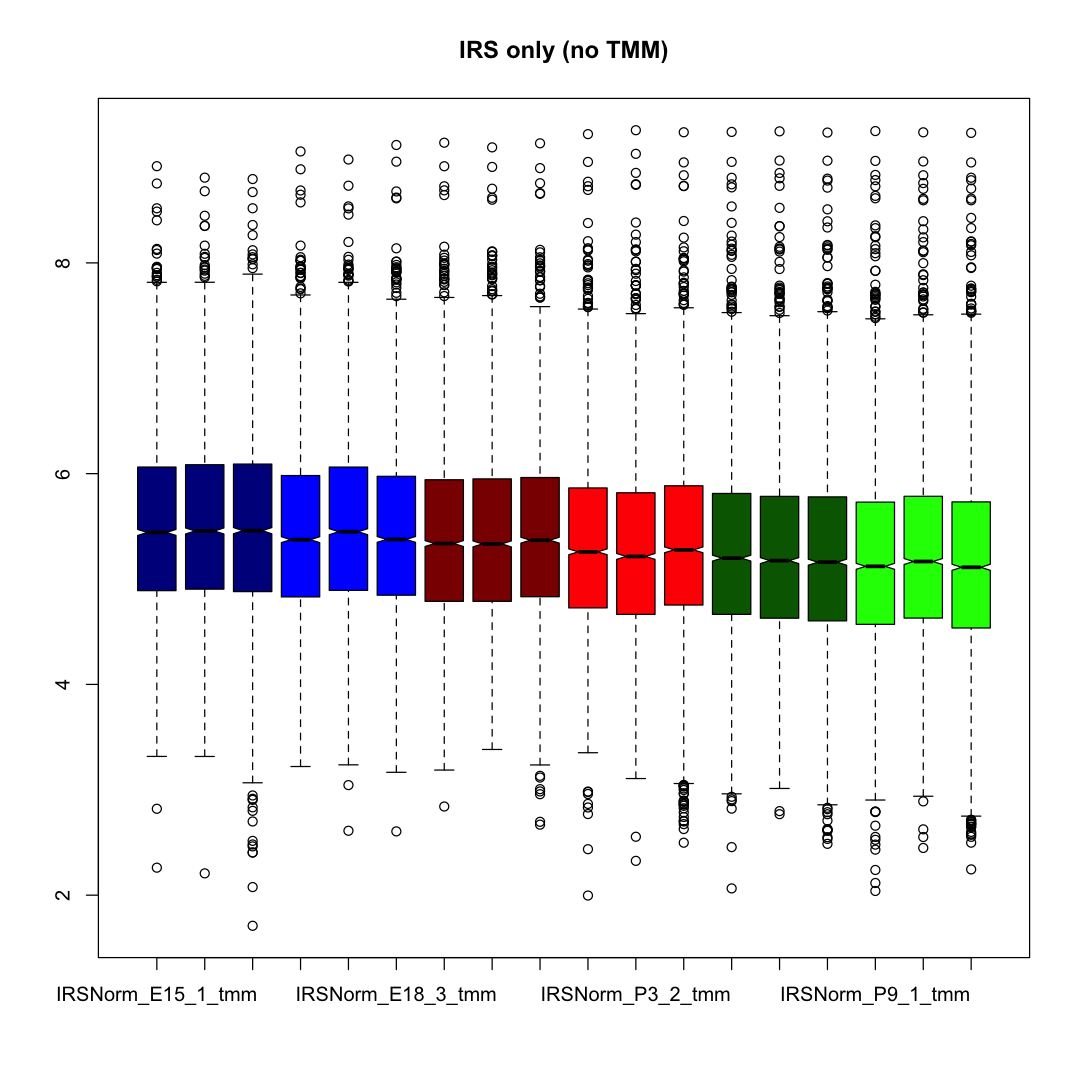

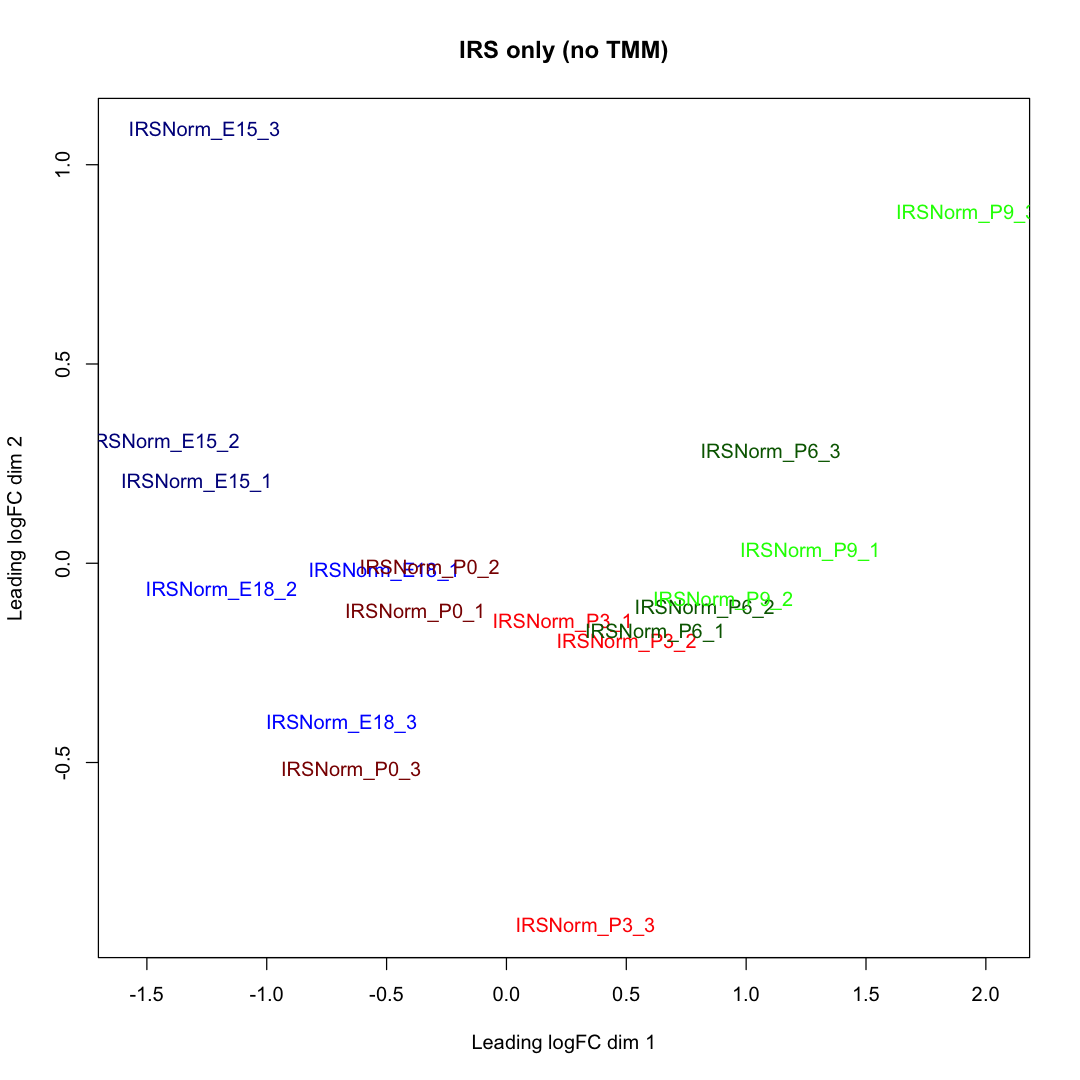

In [5]:
# get the biological sample data into a DGEList object
group_all <- c(rep('E15', 3), rep('E18', 3), rep('P0', 3), 
               rep('P3', 3),  rep('P6', 3),  rep('P9', 3))
y_all <- DGEList(counts = tmt_data, group = group_all, genes = accessions)

# run TMM normalization so we have the results in y
# y_all <- calcNormFactors(y_all)

tmt_tmm_all <- apply_tmm_factors(y_all, table = TRUE, color = colors_all, title = "IRS only (no TMM)")

# check the clustering
plotMDS(y_all, col = colors_all, main = "IRS only (no TMM)")

#### Samples tend to cluster by ages

### Make the design matrix for the testing

In [6]:
# do a one-way ANOVA testing setup
design_all <- model.matrix(~group_all, data = y_all$samples)
colnames(design_all) <- levels(y_all$samples$group)

# check the design matrix
design_all

,E15,E18,P0,P3,P6,P9
IRSNorm_E15_1,1,0,0,0,0,0
IRSNorm_E15_2,1,0,0,0,0,0
IRSNorm_E15_3,1,0,0,0,0,0
IRSNorm_E18_1,1,1,0,0,0,0
IRSNorm_E18_2,1,1,0,0,0,0
IRSNorm_E18_3,1,1,0,0,0,0
IRSNorm_P0_1,1,0,1,0,0,0
IRSNorm_P0_2,1,0,1,0,0,0
IRSNorm_P0_3,1,0,1,0,0,0
IRSNorm_P3_1,1,0,0,1,0,0


### Need to model the dispersion

There seems to be two levels of dispersion. There is the `estimateDisp` function call. After running the linear modeling, we can also check another layer of dispersion associated with the quasi-likelihood modeling.

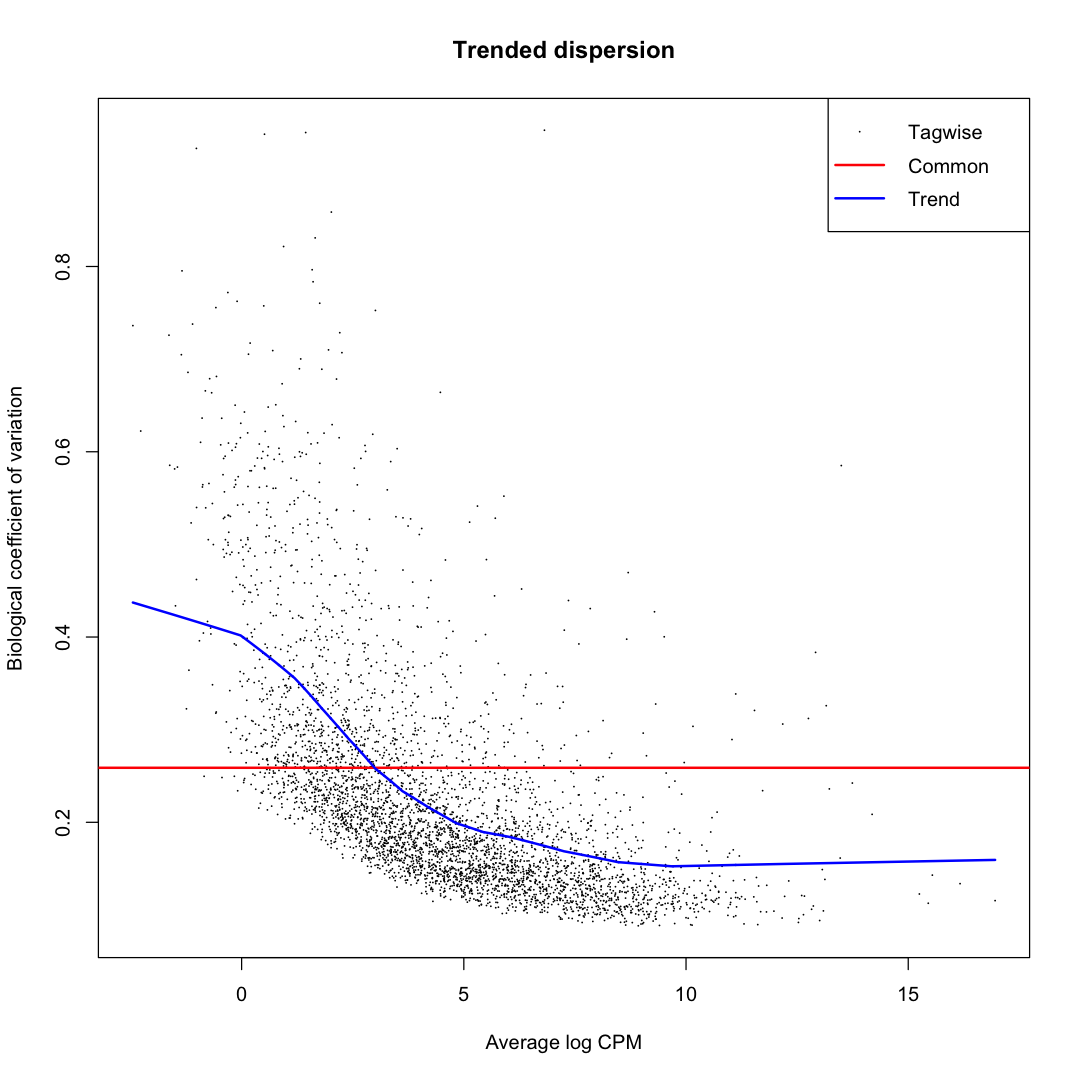

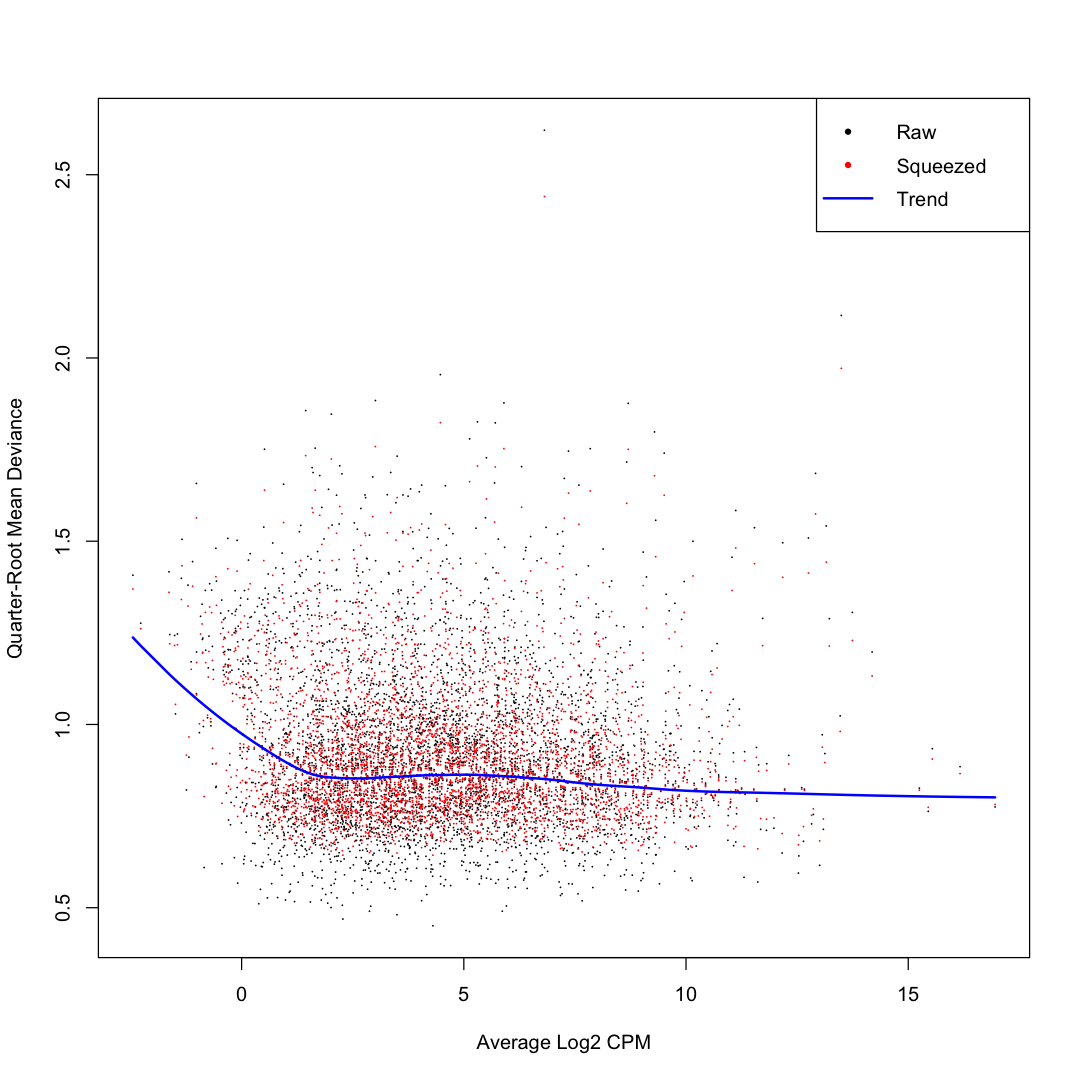

In [7]:
# estimate dispersion in y
y_all <- estimateDisp(y_all, design_all, robust = TRUE)
plotBCV(y_all, main = "Trended dispersion")

# fit statistical models (design matrix already in y$design)
fit_all <- glmQLFit(y_all, design_all, robust = TRUE)
plotQLDisp(fit_all)

### We need to compute p-values for one-way ANOVA testing

,genes,logFC.E18,logFC.P0,logFC.P3,logFC.P6,logFC.P9,logCPM,F,PValue,FDR
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1188,sp|O35658|C1QBP_MOUSE,-1.0325998,-1.2791015,-2.124153,-2.398116,-2.701210,6.141505,117.13287,4.438357e-12,1.121280e-08
75,sp|P63038|CH60_MOUSE,-0.8639710,-1.2002962,-1.917406,-2.324909,-2.771865,10.666751,112.03619,6.279186e-12,1.121280e-08
505,sp|Q61425|HCDH_MOUSE,-0.5073977,-0.8258719,-1.245961,-1.496272,-1.952380,7.951289,106.14898,9.559559e-12,1.121280e-08
63,sp|P20029|BIP_MOUSE,-0.7644831,-1.0162945,-1.819022,-2.100982,-2.493967,10.898630,104.80470,1.055571e-11,1.121280e-08
85,sp|P14211|CALR_MOUSE,-0.6654903,-0.9710300,-1.673301,-1.968147,-2.306239,10.438712,98.70930,1.681210e-11,1.226364e-08
565,sp|Q9CPN8|IF2B3_MOUSE,-0.9321841,-1.2380161,-1.948628,-2.392765,-2.824508,7.832094,97.86749,1.796712e-11,1.226364e-08
95,sp|P09103|PDIA1_MOUSE,-0.5543034,-0.8479906,-1.488886,-1.741376,-2.037842,10.249209,95.75636,2.127703e-11,1.226364e-08
421,sp|Q61595|KTN1_MOUSE,-0.5774175,-0.7882798,-1.394742,-1.619756,-1.933490,8.134434,94.05487,2.444763e-11,1.226364e-08
517,sp|P05202|AATM_MOUSE,-0.7687769,-1.1407622,-1.733271,-2.083914,-2.167319,7.970557,92.44261,2.794955e-11,1.226364e-08


       P9-P6-P3-P0-E18
NotSig             984
Sig               3265

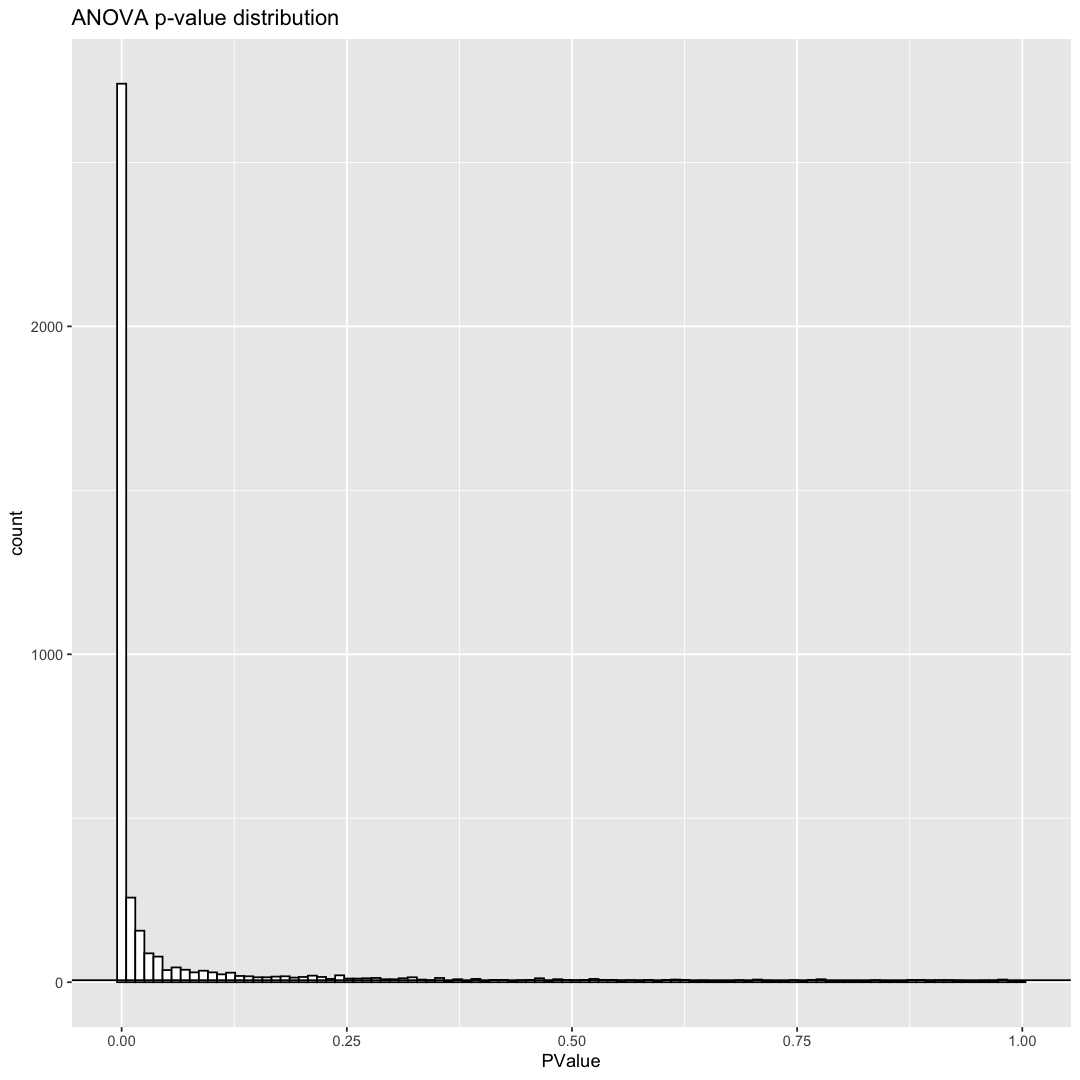

In [8]:
# run the models and then get the ANOVA p-values
qlf_all <- glmQLFTest(fit_all, coef = 2:6)

# check the top tags
topTags(qlf_all)$table
tt_all <- topTags(qlf_all, n = Inf, sort.by = "none")$table

# see how many DE candidates (5% FDR)
summary(decideTestsDGE(qlf_all, p.value = 0.05))

# check the p-value distribution
ggplot(tt_all, aes(PValue)) + 
  geom_histogram(bins = 100, fill = "white", color = "black") + 
  geom_hline(yintercept = mean(hist(tt_all$PValue, breaks = 100, 
                                    plot = FALSE)$counts[26:100])) +
  ggtitle("ANOVA p-value distribution")

### Testing shows about 76% of the proteins vary with time

Without TMM normalization, we have over three quarters of the proteins significantly changing in abundance with age. This is expected because of the over-abundance of major lens proteins (maybe a few hundred) like the crystallins as the lens matures diluting out all the other proteins (several thousand). 

We will have to do some work with the results to see what proteins are going up, staying flatter, or going down with age. ANOVA just tells us which proteins are not flat (within the abundance uncertainties). 

## <a name="summary"></a> Summary

We have many lens proteins changing with mouse development ages from E15 to P9. Young lenses have less accumulated crystallin content and relatively more epithelium and cortex. Young lenses might also have more contamination because they are harder to dissect. 

In [9]:
# collect the results
results <- cbind(tmt_tmm_all, tt_all)

# write the results to disk
write.table(results, "Khan-2018_results_edgeR-ANOVA_noTMM.txt", sep = "\t",
            row.names = FALSE, na =  " ")

## Log the session information

In [10]:
# log the session details
sessionInfo()

R version 3.5.3 (2019-03-11)
Platform: x86_64-apple-darwin15.6.0 (64-bit)
Running under: macOS  10.16

Matrix products: default
BLAS: /Library/Frameworks/R.framework/Versions/3.5/Resources/lib/libRblas.0.dylib
LAPACK: /Library/Frameworks/R.framework/Versions/3.5/Resources/lib/libRlapack.dylib

locale:
[1] en_US.UTF-8/en_US.UTF-8/en_US.UTF-8/C/en_US.UTF-8/en_US.UTF-8

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] psych_2.0.7     edgeR_3.24.3    limma_3.38.3    scales_1.1.1   
 [5] forcats_0.5.0   stringr_1.4.0   dplyr_1.0.2     purrr_0.3.4    
 [9] readr_1.3.1     tidyr_1.1.1     tibble_3.0.3    ggplot2_3.3.2  
[13] tidyverse_1.3.0

loaded via a namespace (and not attached):
 [1] Rcpp_1.0.5       locfit_1.5-9.4   lubridate_1.7.9  lattice_0.20-41 
 [5] assertthat_0.2.1 digest_0.6.25    IRdisplay_0.7.0  R6_2.4.1        
 [9] cellranger_1.1.0 repr_1.1.0       backports_1.1.8  reprex_0.3.0    
[13] evaluate_0